# Grain sizes counting and distribution testing

## Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import ipympl
import imageio.v3 as iio
import skimage

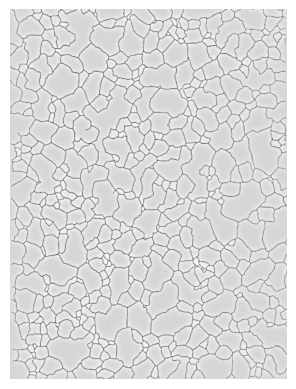

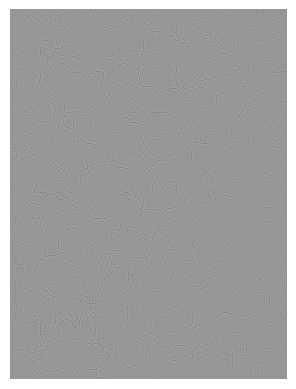

(1861, 1393)


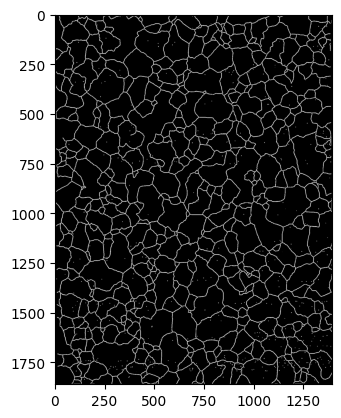

In [2]:
from skimage.filters import gaussian, median, difference_of_gaussians, laplace
from skimage.feature import canny
from skimage import exposure

image_original = iio.imread(uri="data/structures/S2.png")

# fig = plt.figure()
# fig.add_subplot(2, 2, 1)
# plt.imshow(image_original)
# # print(image)
# # image_original.shape
# gray_image = skimage.color.rgb2gray(image_original)
# fig.add_subplot(2, 2, 2)
# plt.imshow(gray_image)
# filtered_image = median(gray_image)
# fig.add_subplot(2, 2, 3)
# plt.imshow(filtered_image)
# image_canny = canny(filtered_image, 1.5)
# image = image_canny.copy()
# fig.add_subplot(2, 2, 4)
# plt.imshow(image, cmap='gray')
# plt.show(block=True)

def preprocess_image(original_image, verbose=True):
    gray_image = skimage.color.rgb2gray(original_image)
    # fig, ax = plt.subplots()
    # plt.axis('off')
    # plt.imshow(gray_image, cmap='gray')
    filtered_image = difference_of_gaussians(gray_image, 1, 12)
    if verbose:
        fig, ax = plt.subplots()
        plt.axis('off')
        plt.imshow(filtered_image, cmap='gray')
    image_edges = laplace(filtered_image, 8)
    image = image_edges.copy()
    if verbose:
        fig, ax = plt.subplots()
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.autoscale(tight=True)
        plt.show()

    p2, p98 = np.percentile(image, (2, 98))
    img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
    img_eq = exposure.equalize_hist(image)
    img_eq[img_eq>0.25] = 1
    img_eq[img_eq<=0.25] = 0
    img_eq = 1 - img_eq
    if verbose:
        fig, ax = plt.subplots()
        plt.imshow(img_eq, cmap='gray')
    image = img_eq
    print(image.shape)
    return image

image = preprocess_image(image_original)

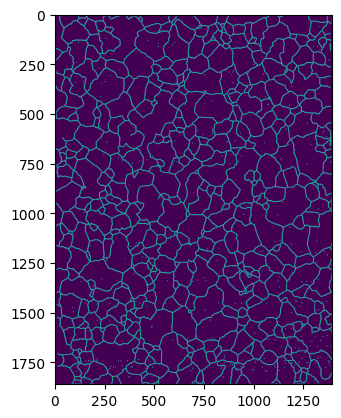

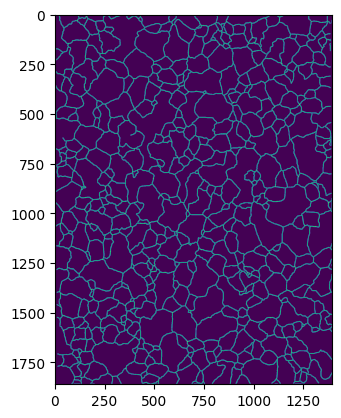

In [3]:
def remove_islands(image, kernel_size=5):
    kernel = np.zeros((kernel_size, kernel_size), np.uint8)
    kernel[:,0] = 1
    kernel[0,:] = 1
    kernel[:,-1] = 1
    kernel[-1,:] = 1
    # print(kernel)


    for i in range(0, image.shape[0]-kernel_size):
        for j in range(0, image.shape[1]-kernel_size):
            border = image[i:i+kernel_size, j:j+kernel_size]
            if((border*kernel).sum() == 0):
                image[i:i+kernel_size, j:j+kernel_size] = 0

remove_islands(image)
fig, ax = plt.subplots()
plt.imshow(image)
remove_islands(image, 10)
fig, ax = plt.subplots()
plt.imshow(image)

## Applicaion

### Grain sizes collecting

(array([12., 15., 13., 12., 13., 11.,  9., 11.,  8.,  8.,  7., 11., 11.,
         8.,  3., 14., 18., 11., 10., 14.,  4., 12.,  9., 10., 11., 13.,
         8., 13., 13.,  0., 17., 10., 10.,  9.,  8., 13., 13., 11., 11.,
        18.,  9., 14.,  7., 13., 15.,  7., 10., 11., 11., 15., 18., 15.,
        12., 15.,  6., 13., 11., 12.,  0., 12.,  8.,  9.,  5.,  8.,  8.,
        11., 15.,  5.,  8.,  6.,  8.,  4.,  7.,  7.,  4.,  6.,  7.,  5.,
         5.,  9.,  4.,  4.,  2.,  6.,  4.,  3.,  9.,  1.,  0.,  6.,  6.,
         4.,  7.,  6.,  4.,  3.,  4.,  5.,  2.,  5.,  5.,  6.,  6.,  2.,
         2.,  3.,  2.,  2.,  2.,  3.,  0.,  2.,  3.,  2.,  3.,  3.,  4.,
         0.,  3.,  2.,  6.,  3.,  2.,  2.,  1.,  1.,  3.,  3.,  3.,  1.,
         0.,  1.,  1.,  2.,  4.,  2.,  2.,  1.,  1.,  2.,  1.,  1.,  1.,
         1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  0.,  2.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.

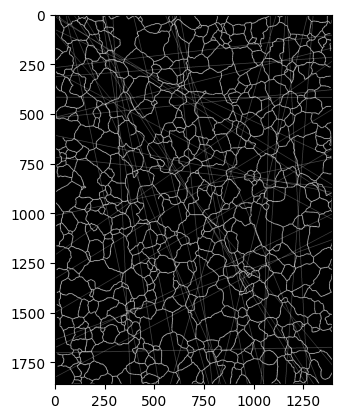

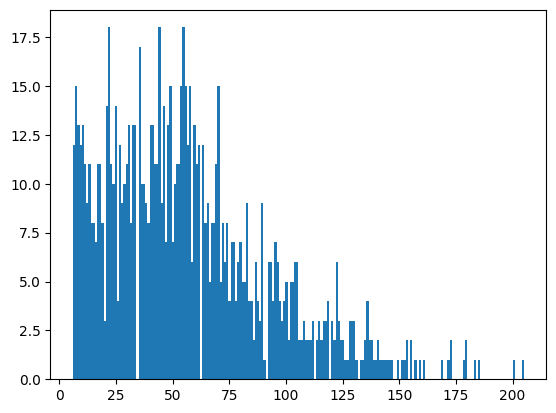

In [4]:
from skimage.draw import line
import random

def get_grains(pixels):
    peaks = pixels.copy()
    for i in range(3, len(pixels)-3):
        if not pixels[i] and pixels[i-1] and not pixels[i-2] and pixels[i+1] and not pixels[i+2]:
            peaks[i] = True
        else:
            if pixels[i] and not pixels[i-1] and pixels[i-2] and not pixels[i+1] and pixels[i+2]:
                peaks[i] = False
    peaks = np.flip(peaks)
    grains = []
    curr_len = 0
    for i in range(len(peaks)):
        if peaks[i]:
            if curr_len > 0:
                grains.append(curr_len)
            curr_len = 0
        else:
            curr_len += 1
    return grains

def collect_grains(image):
    cuts_illustration = np.zeros(image.shape, np.uint8)
    cuts_illustration = image.copy()
    grains = []
    desired_size = 1000
    grain_border_width = 5
    pseudorandomizer = np.random.RandomState(2021)
    while len(grains) < desired_size:
        rand_r1 = random.randrange(image.shape[0])
        rand_c1 = random.randrange(image.shape[1])
        rand_r2 = random.randrange(image.shape[0])
        rand_c2 = random.randrange(image.shape[1])
        if pseudorandomizer.randint(0, 1000) < 500:
            rr, cc = line(rand_r1, 0, rand_r2, image.shape[1]-1)
        else:
            rr, cc = line(0, rand_c1, image.shape[0]-1, rand_c2)
        curr_line_pixels = image[rr, cc]
        cuts_illustration[rr, cc] = 1
        grain_candidates = get_grains(curr_line_pixels)
        for grain in grain_candidates:
            if grain > grain_border_width:
                grains.append(grain)
    return grains, cuts_illustration

grains, cuts_illustration = collect_grains(image)
fig, ax = plt.subplots()
plt.imshow(cuts_illustration, cmap='gray')
fig, ax = plt.subplots()
grains = np.array(grains)
bins = max(grains) + 1
plt.hist(grains, density=False, bins=bins)


In [5]:
from scipy import stats

stats.describe(grains)

DescribeResult(nobs=1011, minmax=(6, 205), mean=56.89020771513353, variance=1335.915656491465, skewness=0.944694069350681, kurtosis=0.7633987748912325)

### Grain sizes distribution testing

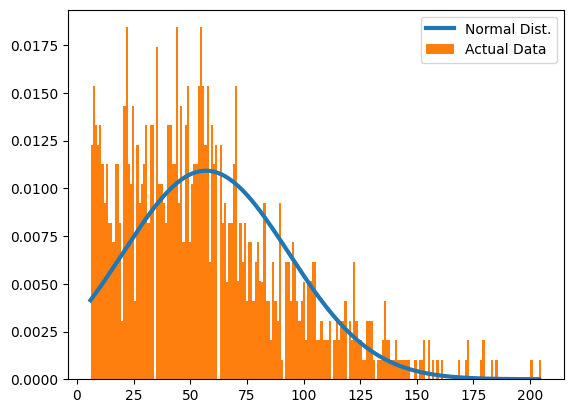


Normaltest p-value is: 0.00 

We have evidence to reject the null hypothesis.


In [6]:
import scipy.stats as stats

def check_p_val(p_val, alpha):
    if p_val < alpha:
        print('We have evidence to reject the null hypothesis.')
    else:
        print('We do not have evidence to reject the null hypothesis.')

xs = np.arange(grains.min(), grains.max(), 1)
params = stats.norm.fit(grains)
fit = stats.norm.pdf(xs, *params)
plt.plot(xs, fit, label='Normal Dist.', lw=3)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend()
plt.show()

stat, p_val = stats.normaltest(grains)
print('\nNormaltest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)

c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu


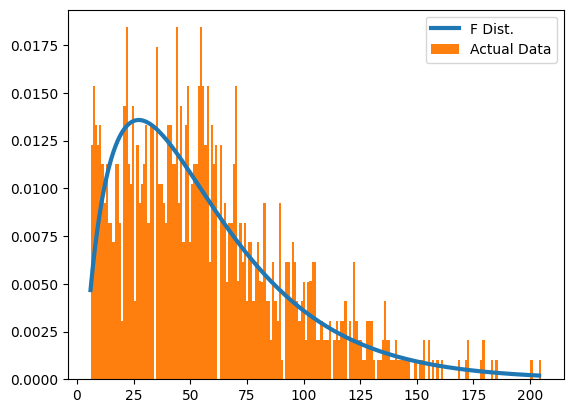


KStest p-value is: 0.01 

We have evidence to reject the null hypothesis.


In [7]:
params = stats.f.fit(grains)
fit = stats.f.pdf(xs, *params)
plt.plot(xs, fit, label='F Dist.', lw=3)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend()
plt.show()

stat, p_val = stats.kstest(grains, 'f', args=params)
print('\nKStest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)

c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.2.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.133333333333333.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.8888888888888884.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.122222222222222.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang di

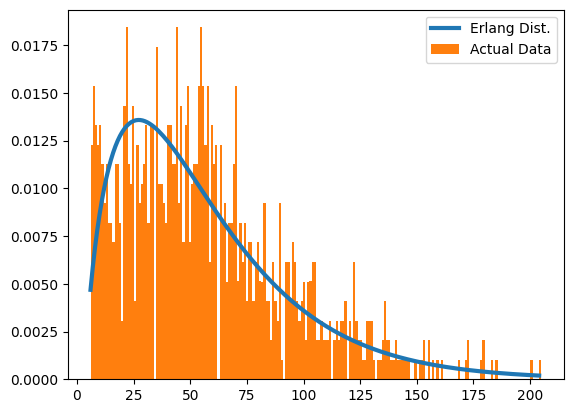


KStest p-value is: 0.01 

We have evidence to reject the null hypothesis.


In [8]:
params = stats.erlang.fit(grains)
fit = stats.erlang.pdf(xs, *params)
plt.plot(xs, fit, label='Erlang Dist.', lw=3)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend()
plt.show()

stat, p_val = stats.kstest(grains, 'erlang', args=params)
print('\nKStest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)

In [9]:
import scipy.stats as st

dist_names = ["norm", "lognorm", "alpha", "beta", "betaprime", "gamma", "expon", "exponnorm", "t", "erlang", "f", "gibrat"]

def get_best_distribution(data):
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

best_dist, best_p, best_params = get_best_distribution(grains)


p value for norm = 7.520229807660885e-07
p value for lognorm = 0.10833456573304323
p value for alpha = 7.100845733971119e-39
p value for beta = 0.012679092985130624

c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:874: RuntimeWarning: divide by zero encountered in divide
  a/(b-1.0),
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:878: RuntimeWarning: divide by zero encountered in divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),



p value for betaprime = 0.011730120209934754
p value for gamma = 0.009836543616159788
p value for expon = 4.33721110971115e-15
p value for exponnorm = 0.01159911108998057
p value for t = 7.530897733885265e-07
p value for erlang = 0.009835947111989377
p value for f = 0.01015458344521003
p value for gibrat = 5.030271830298694e-10
Best fitting distribution: lognorm
Best p value: 0.10833456573304323
Parameters for the best fit: (0.48141460856887774, -19.556339344231386, 68.31235693951635)


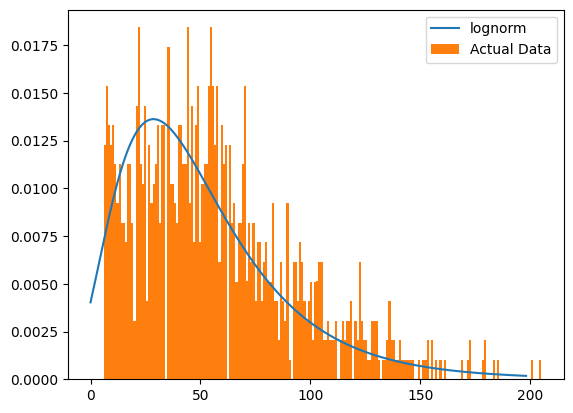

In [10]:
def illustrate_best_fit(dist_name, params):
    dist = getattr(st, dist_name)
    pdf_fitted = dist.pdf(xs, *params)
    plt.plot(pdf_fitted, label=dist_name)
    plt.hist(grains, bins, density=True, label='Actual Data')
    plt.legend(loc='upper right')
    plt.show()

illustrate_best_fit(best_dist, best_params)

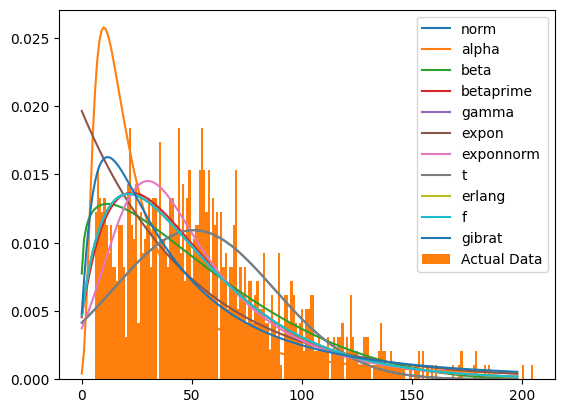

In [11]:
xs = np.arange(grains.min(), grains.max(), 1)
dist_names = ["norm", "alpha", "beta", "betaprime", "gamma", "expon", "exponnorm", "t", "erlang", "f", "gibrat"]

for dist_name in dist_names:
    dist = getattr(st, dist_name)
    params = dist.fit(grains)
    pdf_fitted = dist.pdf(xs, *params)
    plt.plot(pdf_fitted, label=dist_name)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend(loc='upper right')
plt.show()

### Process samples

In [12]:
samples = [
 "data/structures/S1.png",
 "data/structures/S2.png",
 "data/structures/S3.png",
 "data/structures/S4.png",
 "data/structures/S5.png",
 "data/structures/S6.png",
 "data/structures/S7.png",
]

Processing: data/structures/S1.png
(1605, 1141)


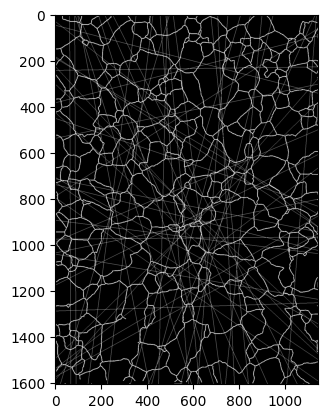

DescribeResult(nobs=1001, minmax=(6, 259), mean=65.35464535464536, variance=1931.7671008991006, skewness=1.1240564688238854, kurtosis=1.3895417528816285)
p value for norm = 3.031736050190376e-07
p value for alpha = 1.3028302447566029e-39
p value for beta = 0.06203471960440099
p value for betaprime = 0.1585537994734506
p value for gamma = 0.10068342556724907
p value for expon = 1.344091855616473e-13
p value for exponnorm = 0.00698263245010127
p value for t = 3.032389904822692e-07
p value for erlang = 0.10067997489640013


c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.1500000000000004.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.1000000000000005.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.916666666666667.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.091666666666667.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter o

p value for f = 0.09545737359582607
p value for gibrat = 1.1659549303800575e-07
Best fitting distribution: betaprime
Best p value: 0.1585537994734506
Parameters for the best fit: (1.9111197695452793, 10535.39449721992, 2.5676415799839636, 342635.94066277426)


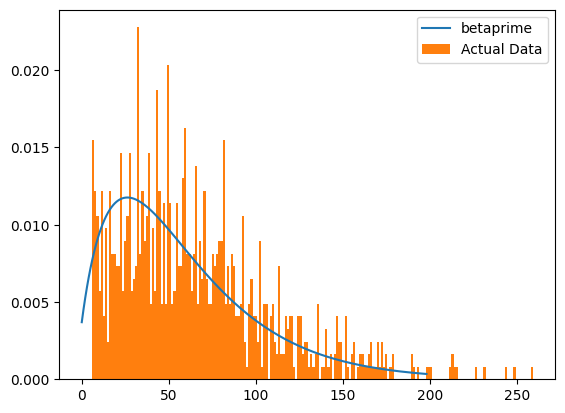

Processing: data/structures/S2.png
(1861, 1393)


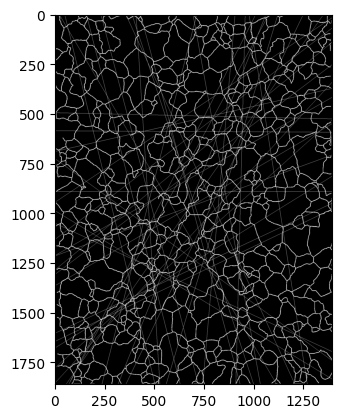

DescribeResult(nobs=1022, minmax=(6, 281), mean=54.2426614481409, variance=1299.539490657063, skewness=1.1246251837029566, kurtosis=2.1379762113773157)
p value for norm = 1.058465035458921e-07
p value for alpha = 8.615449739833506e-43
p value for beta = 0.0006145950901952435


c:\Work\learn\grains\.venv\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


p value for betaprime = 0.028371071546121174
p value for gamma = 0.0009371749782941923
p value for expon = 1.7318564069607006e-12
p value for exponnorm = 3.377844410533958e-05
p value for t = 6.278842924885488e-08


c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.8499999999999996.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.8999999999999995.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.9749999999999996.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.1333333333333337.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter

p value for erlang = 0.0009371247213849688
p value for f = 0.0010336026556857986
p value for gibrat = 5.706596968423187e-09
Best fitting distribution: betaprime
Best p value: 0.028371071546121174
Parameters for the best fit: (2.6603476476014816, 25.1610328012046, -3.0345599186245202, 521.0571885016379)


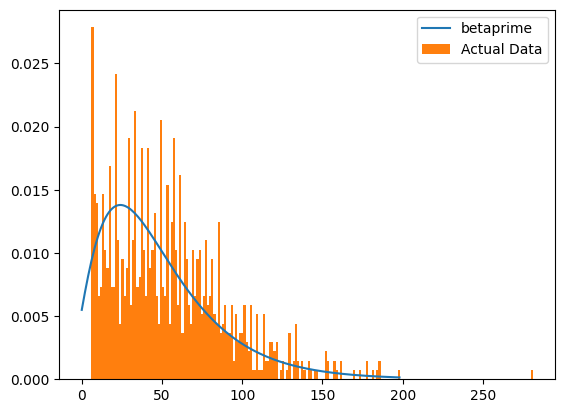

Processing: data/structures/S3.png
(1741, 1221)


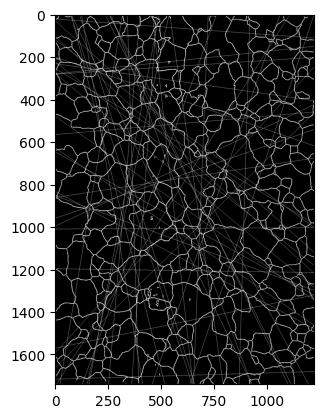

DescribeResult(nobs=1013, minmax=(6, 287), mean=64.23790720631787, variance=1904.6874153787328, skewness=1.0009789578611312, kurtosis=1.1092495982804937)
p value for norm = 9.741060290529186e-08
p value for alpha = 2.2135150252987764e-38
p value for beta = 0.0834922830316196
p value for betaprime = 0.0013044528729361103
p value for gamma = 0.008590480693244812
p value for expon = 1.7800696092448804e-09
p value for exponnorm = 2.4950820680956486e-09
p value for t = 2.618407481212514e-10
p value for erlang = 0.008591272359213458


c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.0249999999999995.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.083333333333333.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.1374999999999993.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.1083333333333334.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter 

p value for f = 0.009488469483503128
p value for gibrat = 1.7060801555562475e-07
Best fitting distribution: beta
Best p value: 0.0834922830316196
Parameters for the best fit: (1.1653853904818807, 5.236896658513881, 5.859090362324203, 318.9908010347577)


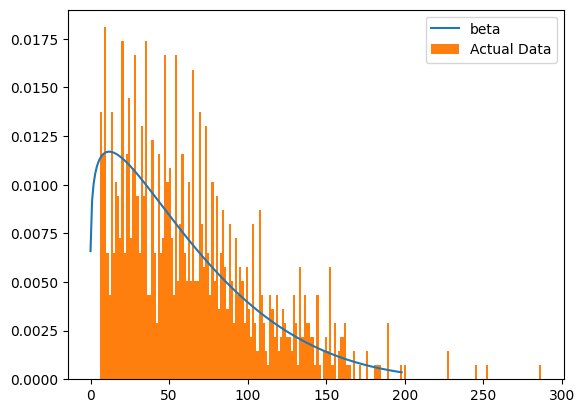

Processing: data/structures/S4.png
(446, 567)


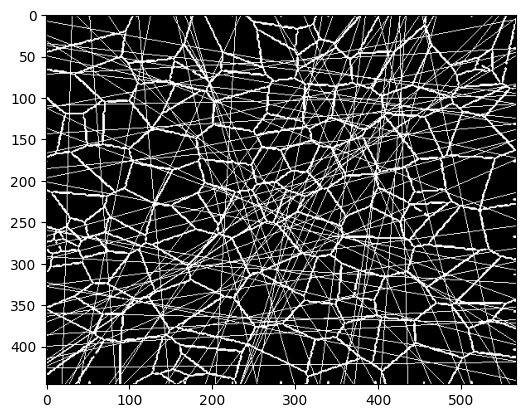

DescribeResult(nobs=1016, minmax=(6, 88), mean=31.15255905511811, variance=253.2702988635041, skewness=0.7021429785132334, kurtosis=0.2681915465620448)
p value for norm = 0.00019286761480236022
p value for alpha = 0.06588559285630224
p value for beta = 0.010691969067604726
p value for betaprime = 0.03697982978964076
p value for gamma = 0.016164955964296655
p value for expon = 2.7971190105311094e-26
p value for exponnorm = 0.04279373666911124
p value for t = 0.0001937631563109375
p value for erlang = 0.016166942003375335


c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 8.4.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 7.6.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 7.733333333333334.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 7.933333333333334.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has 

p value for f = 0.012066154555037775
p value for gibrat = 3.0930592883421693e-15
Best fitting distribution: alpha
Best p value: 0.06588559285630224
Parameters for the best fit: (6.688435057809716, -69.94217888678983, 660.5395487134906)


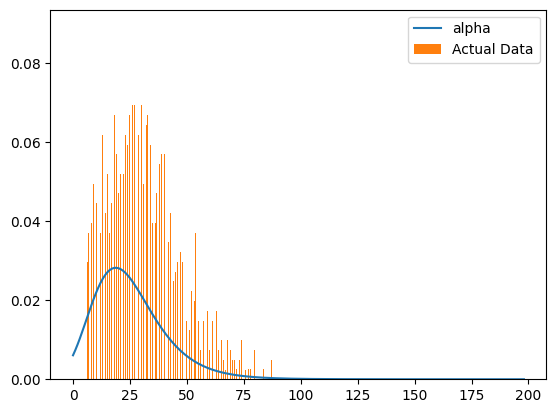

Processing: data/structures/S5.png
(446, 567)


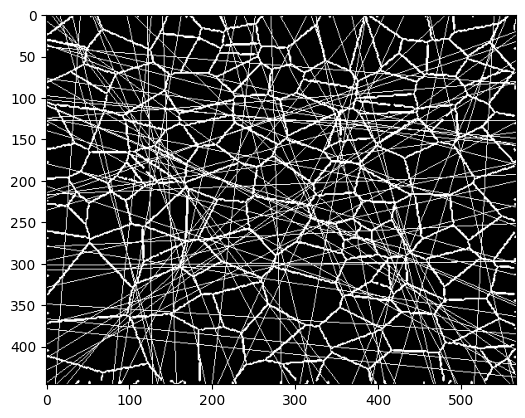

DescribeResult(nobs=1001, minmax=(6, 91), mean=30.89210789210789, variance=262.0343476523476, skewness=0.6792329451552571, kurtosis=0.20186206495215142)
p value for norm = 0.0002525883040582112
p value for alpha = 0.08464443395902121
p value for beta = 0.00047454652423002826
p value for betaprime = 0.005375526699846
p value for gamma = 0.007048355917842078
p value for expon = 4.97361040711757e-26
p value for exponnorm = 0.06188511086168247
p value for t = 0.00025342527902312697
p value for erlang = 0.00704868480098649


c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 8.014609053497946.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 8.058179012345683.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 8.046296296296301.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 8.010648148148157.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of 

p value for f = 0.009620626085126878
p value for gibrat = 2.8547762364592034e-16
Best fitting distribution: alpha
Best p value: 0.08464443395902121
Parameters for the best fit: (6.838178786249398, -74.52027734732327, 704.9194608093326)


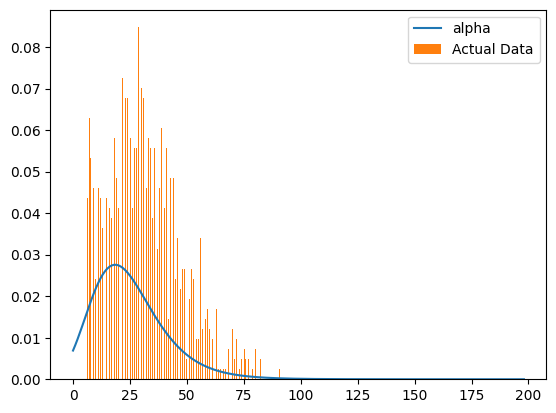

Processing: data/structures/S6.png
(439, 567)


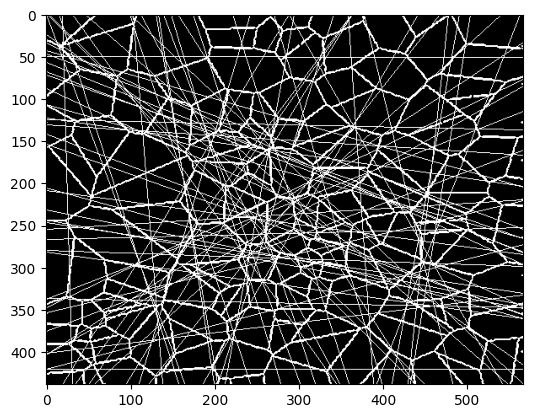

DescribeResult(nobs=1000, minmax=(6, 97), mean=29.021, variance=240.08464364364366, skewness=0.7996216948856208, kurtosis=0.7980173244305488)
p value for norm = 0.00015598783788632956
p value for alpha = 0.03935376340967878
p value for beta = 0.000404285525343228
p value for betaprime = 0.0076563849759010375
p value for gamma = 0.0009086591990720265
p value for expon = 4.948011879982659e-21
p value for exponnorm = 0.023142686845576074
p value for t = 2.7370973532592778e-05
p value for erlang = 0.0009085958766393194
p value for f = 0.0008827367605454055
p value for gibrat = 8.949485033551369e-14
Best fitting distribution: alpha
Best p value: 0.03935376340967878
Parameters for the best fit: (6.352361579214312, -63.709960145580375, 573.899425347766)


c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 6.300000000000001.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 5.699999999999999.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 5.799999999999999.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 5.949999999999999.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of 

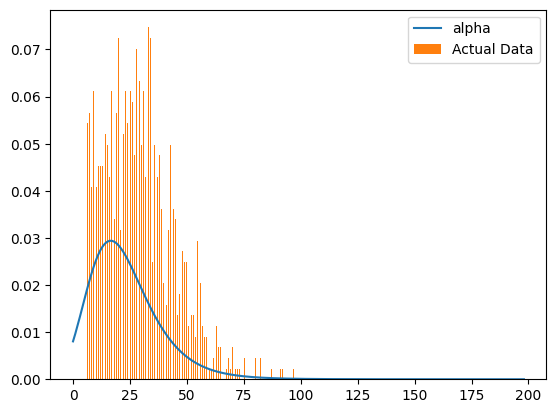

Processing: data/structures/S7.png
(436, 564)


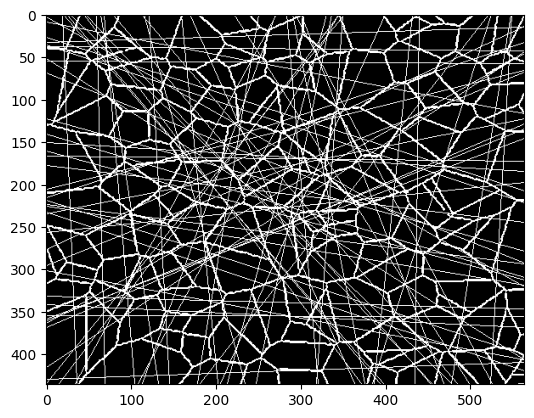

DescribeResult(nobs=1004, minmax=(6, 120), mean=29.19422310756972, variance=235.60231953541765, skewness=0.8852183686896217, kurtosis=1.4030164102436489)
p value for norm = 0.00028926556418748517
p value for alpha = 0.013421749914752968
p value for beta = 0.003558808947024312
p value for betaprime = 0.01680087317369073
p value for gamma = 0.0035584535512180877
p value for expon = 1.0697144045432517e-20
p value for exponnorm = 0.004631972688382046
p value for t = 6.127876389727208e-05


c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 5.25.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.75.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.833333333333334.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.958333333333334.
  warnings.warn(
c:\Work\learn\grains\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:3100: RuntimeWarning: The shape parameter of the erlang distribution ha

p value for erlang = 0.0035586857161853994
p value for f = 0.0037354555608693695
p value for gibrat = 1.0740995936245917e-11
Best fitting distribution: betaprime
Best p value: 0.01680087317369073
Parameters for the best fit: (4847.822254290633, 13.827634038257408, -25.27700152990367, 0.14425727600217123)


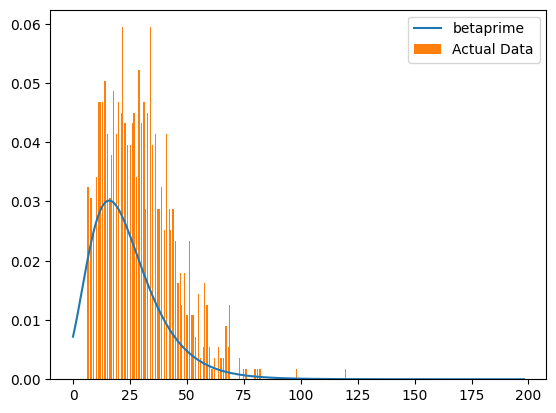

In [13]:
for sample in samples:
    print("Processing: " + sample)
    image_original = iio.imread(uri=sample)
    image = preprocess_image(image_original, verbose=False)
    remove_islands(image)
    remove_islands(image, 10)
    grains, cuts_illustration = collect_grains(image)
    plt.imshow(cuts_illustration, cmap='gray')
    plt.show()
    print(stats.describe(grains))
    best_dist, best_p, best_params = get_best_distribution(grains)
    illustrate_best_fit(best_dist, best_params)